In [ ]:
## Init Bionic VTOL
include("../Flyonic.jl");
using .Flyonic;

using Rotations; # used for initial position

using ReinforcementLearning;
using StableRNGs;
using Flux;
using Flux.Losses;
using Random;
using IntervalSets;
using LinearAlgebra;
using Distributions;

using Plots;
using Statistics;

using BSON: @save, @load # save mode
create_visualization();

# indicates how many threads Julia was started with. This is important for the multi-threaded environment
Threads.nthreads()
### Create Reinforcement Learning Environment

################################ TODO ################################
# You can initialization global constants here.
# E.g. a fixed point in the beginning of training (for testing/overfitting)
# Define global constants for initial position and rotation

#####
##### first coordinate - red axis - x
##### second coordinate - green axis - y
##### third coordinate - blue axis - z
#####
x_init = [0.0, 0.0, 0.0];
rot_init = Matrix(UnitQuaternion(RotZ(-pi/2.0) * RotY(-pi/2.0) * RotX(pi)));

# Defaault values for VtolEnv variables
waypoints_default = generate_trajectory(2);
proximity_tolerance_default = 0.5;
timeout_default = 30.0;

v_min_default = 1.0;
v_max_default = 2.0;
w_max_default = 15.0;

succes_dist_default = 0.25;
######################################################################

In [17]:
mutable struct VtolEnv{A,T,ACT,R<:AbstractRNG} <: AbstractEnv # Parametric Constructor for a subtype of AbstractEnv
    action_space::A # action space
    observation_space::Space{Vector{ClosedInterval{T}}} # observation space
    state::Vector{T} # current state space
    action::ACT # action space
    done::Bool # done
    t::T # time
    rng::R # random number generator

    name::String # for multible environments
    visualization::Bool # visualization
    realtime::Bool # realtime

    x_previous::Vector{T} # previous position
    x_W::Vector{T} # current position
    v_B::Vector{T} # velocity
    R_W::Matrix{T} # current rotation
    w_B::Vector{T} # rotation velocitiy
    wind_W::Vector{T} # wind
    delta_t::T # simulation time step

    ################################ TODO ################################
    # Extend the environment here.
    # Everything you need additionaly in your environment also go in here.
    # E.g. a trajectory

    # Pathway variables
    waypoints::Vector{Vector{T}}
    proximity_tolerance::T
    timeout::T
    succes_dist::T

    # Kinetic variables
    v_min::T
    v_max::T # maximum allowed velocity
    w_max::T # maximum allowed velocity


    ######################################################################
end


# define a keyword-based constructor for the type declared in the mutable struct typedef.
# It could also be done with the macro Base.@kwdef.
function VtolEnv(;
    rng = Random.GLOBAL_RNG, # random number generation
    name = "vtol",
            visualization = false,
    realtime = false,
    kwargs...) # let the function take an arbitrary number of keyword arguments

    T = Float64; # explicit type which is used e.g. in state. Cannot be altered due to the poor matrix defininon.
    A = Space{Vector{ClosedInterval{T}}};

    action_space = Space(
        ClosedInterval{T}[
            0.0..2.0, # propeller 1
            0.0..2.0, # propeller 2
            ],
    ) # propeller 1 and 2

    state_space = Space( # Three continuous values in state space.
        ClosedInterval{T}[
            ################################ TODO ################################
            # Implement an observation space.
            # Here is an example space. You can change it if desired.
            # You have to extend it.
            # Orientate yourself on the observation space from the paper.

            typemin(T)..typemax(T), #1 previous position along x WORLD coordinates
            typemin(T)..typemax(T), #2 previous position along z WORLD coordinates

            typemin(T)..typemax(T), #3 current position along x WORLD coordinates
            typemin(T)..typemax(T), #4 current position along z WORLD coordinates

            typemin(T)..typemax(T), #5 velocity along x BODY coordinates
            typemin(T)..typemax(T), #6 velocity along y BODY coordinates

            typemin(T)..typemax(T), #7 rotational velocity along z BODY coordinates

            typemin(T)..typemax(T), #8 alive time

            typemin(T)..typemax(T), #9 left actuator fire
            typemin(T)..typemax(T), #10 right actuator fire
            ######################################################################
            ],
    )

    if visualization # visualizes VTOL
        create_VTOL(name, actuators = true, color_vec=[1.0; 1.0; 0.6; 1.0]);
    end

    environment = VtolEnv(
        action_space, # action space
        state_space, # observation space
        zeros(T, length(state_space)), # current state space
        rand(action_space), # initialization action
        false, # episode done
        0.0, # time
        rng, # random number generator

        name,
        visualization,
        realtime,

        zeros(T, 3), # x_previous, previous position
        zeros(T, 3), # x_W, current position
        zeros(T, 3), # v_B, velocity
        rot_init, # R_W, current rotation
        zeros(T, 3), # w_B
        zeros(T, 3), # wind_W
        T(0.02), # simulation time step

        ################################## TODO ##################################
        # Initialization everything you need additionaly in your environment here

        waypoints_default,
        proximity_tolerance_default,
        timeout_default,
        succes_dist_default,
        v_min_default,
        v_max_default,
        w_max_default,

        ##########################################################################
    )

    reset!(environment)
    return environment
end;

methods(VtolEnv)

# Just for explanation:
# 1. A mutable Struct is created. A struct is a constructor and a constructor is a function that creates new objects.
# 2. A outer keyword-based constructor method is added for the type declared in the mutable struct typedef before.'
# So now we have a function with two methods. Julia will decide which method to call by multiple dispatch.

## Define the RL interface

Random.seed!(env::VtolEnv, seed) = Random.seed!(env.rng, seed)
RLBase.action_space(env::VtolEnv) = env.action_space
RLBase.state_space(env::VtolEnv) = env.observation_space
RLBase.is_terminated(env::VtolEnv) = env.done
RLBase.state(env::VtolEnv) = env.state

function computeReward(env::VtolEnv{A,T}) where {A,T}
    reward = 0.0

    ################################ TODO ################################
    # Implement the reward function.
    # Orientate on the paper.

    # Hyperparameters
    kp = 5.0;
    kw = 0.01;
    kwp = 5.0;
    # max distance
    dmax = 0.3;
    kd = 0.03;

    # Gates and their length
    gates = env.waypoints;
    n = length(gates);
    # closest point on the guiding path phi
    # its line-segment index lp
    x_old = [env.state[1], 0.0, env.state[2]];
    x_new = [env.state[3], 0.0, env.state[4]];
    lp_old, phi_old = calculate_progress(gates, x_old);
    lp_new, phi_new = calculate_progress(gates, x_new);
    # previous time step spt_old
    # current time step spt_new
    spt_old = norm(phi_old - gates[lp_old]);
    spt_new = norm(phi_new - gates[lp_new]);
    # rogress reward rpt at time t is as a difference in reached
    # distance between the current and previous time step
    rpt = spt_new - spt_old
    spt = spt_new

    # The sum that is later going to be the divisor
    # for the reached distance reward
    divisor_g = norm(gates[2] - gates[1]);
    # reached distance reward ks
    ks = 6.0 * env.v_max * env.delta_t / divisor_g;

    # steered at waypoint must be 1 bigger than the current line segment
    # distance to new waypoint dw
    dwp = norm(x_new - gates[2]);
    # tolerance for proximity to a waypoint
    r_tol = env.proximity_tolerance;
    # waypoint reward rwp
    rwp = dwp <= r_tol ? exp(-dwp/r_tol) : 0.0;

    # absolute velocity
    v_vector = [env.state[5], env.state[6], 0.0]
    v = norm(v_vector);
    # rotation speed
    w = abs(env.state[7]);


    # distance from closes point on the guiding path
    gd = norm(x_new - phi_new);
    # Scaling factors
    svmax = v > env.v_max ? 10^(env.v_max - v) : 1.0;
    svmin = v < env.v_min ?  10^(v - env.v_min) : 1.0;
    sgd = gd > dmax  ? exp(dmax - gd) : 1.0;
    # Ultimate scaling factor
    s = svmax * svmin * sgd;
    # Scaling the rewards
    kp = s * kp;
    ks = s * ks;

    ### Extra rewards
    # proximity to path tolerance
    path_tol = 0.3 * norm(env.waypoints[2] - env.waypoints[1]);
    # staying alive as long as possible
    k_stayup = 0.8;
    r_stayup = env.state[4] >= 0 && gd <= path_tol ? exp(-(gd + dwp)) : 0.0;
    # having a small actuator difference
    k_propeller = 0.5;
    r_propeller = exp(-(abs(env.state[9] - env.state[10])));
    # Having reached the target
    r_succes = dwp <= env.succes_dist ? 1000000.0 * exp(-env.t) : 0.0;

    # Sum it all
    rewards = kp * rpt + ks * spt + kwp * rwp + k_stayup *r_stayup + k_propeller * r_propeller + r_succes;
    punishments = kw * w + kd * dwp + kd * gd;
    total_reward = rewards - punishments;

    ################################################################################################

    return total_reward
end

RLBase.reward(env::VtolEnv{A,T}) where {A,T} = computeReward(env)

function RLBase.reset!(env::VtolEnv{A,T}) where {A,T}
    # Visualize initial state
    if env.visualization
        set_transform(env.name, env.x_W, QuatRotation(env.R_W));
        set_actuators(env.name, [0.0; 0.0; 0.0; 0.0]);
    end

    env.x_W = [0.0; 0.0; 0.0];
    env.v_B = [0.0; 0.0; 0.0];
    env.R_W = rot_init;

    env.w_B = [0.0; 0.0; 0.0];
    env.wind_W = [0.0; 0.0; 0.0];

    env.t = 0.0;
    env.action = [0.0, 0.0];
    env.done = false;

    ################################ TODO ################################
    # Reset environment.
    # Is called if the training terminates
    # (e.g. if drone crashes or successfully reaches point)
    # HINT: Everything you added to your environment needs to be reseted.
    #       Compare it with the initialization.

    env.state[1] = env.x_previous[1]; # update previous x-coordinate
    env.state[2] = env.x_previous[3]; # update previous z-coordinate

    env.state[3] = env.x_W[1]; # position along x
    env.state[4] = env.x_W[3]; # position along z

    env.state[5] = env.v_B[1]; # velocity along x BODY coordinates
    env.state[6] = env.v_B[2]; # velocity along y BODY coordinates

    env.state[7] = env.w_B[3];  # rotational velocity along z BODY coordinates

    env.state[8] = env.t; # time the drone is actually alive

    env.state[9] = env.action[1] # propeller 1
    env.state[10] = env.action[2]; #  propeller 2

    env.x_previous = x_init; # starting position
    env.delta_t = T(0.02); # Δ time

    env.waypoints = waypoints_default;
    env.proximity_tolerance = proximity_tolerance_default;
    env.timeout = timeout_default;
    env.succes_dist = succes_dist_default;
    env.v_min = v_min_default;
    env.v_max = v_max_default;
    env.w_max = w_max_default;

    # Visualize the waypoints
    radius = 0.1;
    visualize_waypoints(env.waypoints, radius);
    ######################################################################

    nothing
end;

# defines a methods for a callable object.
# So when a VtolEnv object is created, it has this method that can be called
function (env::VtolEnv)(a)
    # set the propeller trust and the two flaps 2D case
    # flaps set to 0.0
    next_action = [a[1], a[2], 0.0, 0.0]

    _step!(env, next_action)
end

env = VtolEnv();
methods(env) # Just to explain which methods the object has


function _step!(env::VtolEnv, next_action)
    # Update previous
    env.x_previous = [env.state[3], 0.0, env.state[4]];

    # caluclate wind impact
    v_in_wind_B = vtol_add_wind(env.v_B, env.R_W, env.wind_W);

    # caluclate aerodynamic forces
    torque_B, force_B = vtol_model(v_in_wind_B, next_action, eth_vtol_param);

    # Limit to 2D
    force_B[3] = 0.0; # Body Z
    env.v_B[3] = 0.0;
    torque_B[1] = 0.0;
    torque_B[2] = 0.0;  # Body X and Y
    env.w_B[1] = 0.0;
    env.w_B[2] = 0.0;

    # integrate rigid body dynamics for delta_t
    env.x_W, env.v_B, env.R_W, env.w_B, time = rigid_body_simple(torque_B, force_B, env.x_W, env.v_B, env.R_W, env.w_B, env.t, env.delta_t, eth_vtol_param);

    if env.realtime
        sleep(env.delta_t); # just a dirty hack. this is of course slower than real time.
    end

    # Visualize the new state
    if env.visualization
        set_transform(env.name, env.x_W, QuatRotation(env.R_W));
        set_actuators(env.name, next_action);
    end

    env.t += env.delta_t

    ################################ TODO ################################

    env.state[1] = env.x_previous[1]; # update previous x-coordinate
    env.state[2] = env.x_previous[3]; # update previous z-coordinate

    env.state[3] = env.x_W[1]; # position along x
    env.state[4] = env.x_W[3]; # position along z

    env.state[5] = env.v_B[1]; # velocity along x BODY coordinates
    env.state[6] = env.v_B[2]; # velocity along y BODY coordinates

    env.state[7] = env.w_B[3];  # rotational velocity along z BODY coordinates

    env.state[8] = env.t; # time the drone is actually alive

    env.state[9] = env.action[1] # propeller 1
    env.state[10] = env.action[2]; #  propeller 2

    # Instead of the floor level which assumes the simulation will only run upstairs,
    # Here a variables for being too far from the next wp after reaching a previous waypoint can be used instead

    segment_length = norm(env.waypoints[2] - env.waypoints[1])
    k_failure = 1.4;
    wp_dist = norm(env.waypoints[2] - env.x_W)

    env.done =
        norm(env.w_B) > env.w_max || # stop if body rate is too high
        wp_dist > k_failure * segment_length ||
        env.t > env.timeout ||
        wp_dist < env.succes_dist;
    ######################################################################

    nothing
end;

RLBase.test_runnable!(env)

# changed to 10s (5s before) per point and 5.0m too far off path (2.0 before)
# Show an overview of the environment.

## Setup of a reinforcement learning experiment.

seed = 123
rng = StableRNG(seed)
    N_ENV = 8
    UPDATE_FREQ = 1024

    vtol_envs = [
        # use different names for the visualization
        VtolEnv(; rng = StableRNG(hash(seed+i)), name = "vtol$i") for i in 1:N_ENV
    ];
    # define multiple environments for parallel training
    env = MultiThreadEnv(vtol_envs)

    # Define the function approximator
    # TODO: research briefly what Actor Critic is
    # TODO: research what ADAM is
    # Define the function approximator
    ns, na = length(state(env[1])), length(action_space(env[1]))
    #ActorCritic Policy
    approximator = ActorCritic(
                #ns - number states as input
                #3 layer; last layer splitted in mean and variance; then action is sampled
                actor = GaussianNetwork(
                    pre = Chain(
                        Dense(ns, 32, relu; initW = glorot_uniform(rng)),
                        Dense(32, 16, relu; initW = glorot_uniform(rng)),
                        Dense(16, 16, relu; initW = glorot_uniform(rng)),
                    ),
                    μ = Chain(
                        Dense(16, na; initW = glorot_uniform(rng))
                    ),
                    logσ = Chain(
                        Dense(16, na; initW = glorot_uniform(rng))
                    ),
                ),
                critic = Chain(
                    Dense(ns, 32, relu; initW = glorot_uniform(rng)),
                    Dense(32, 16, relu; initW = glorot_uniform(rng)),
                    Dense(16, 1; initW = glorot_uniform(rng)),
                ),
                optimizer = ADAM(1e-3),
            );

        agent = Agent( # A wrapper of an AbstractPolicy
        # AbstractPolicy: the policy to use
        # (optional) TODO: change eventually
        # TODO: research briefly what PPO is
        policy = PPOPolicy(;
                    approximator = approximator |> gpu,
                    update_freq=UPDATE_FREQ,
                    dist = Normal,
                    # For parameters visit the docu: https://juliareinforcementlearning.org/docs/rlzoo/#ReinforcementLearningZoo.PPOPolicy
                    ),

        # AbstractTrajectory: used to store transitions between an agent and an environment source
        trajectory = PPOTrajectory(;
            capacity = UPDATE_FREQ,
            state = Matrix{Float64} => (ns, N_ENV),
            action = Matrix{Float64} => (na, N_ENV),
            action_log_prob = Vector{Float64} => (N_ENV,),
            reward = Vector{Float64} => (N_ENV,),
            terminal = Vector{Bool} => (N_ENV,),
        ),
    );


function saveModel(t, agent, env)
    model = cpu(agent.policy.approximator)
    f = joinpath("./RL_models_2dpoint_leo/", "vtol_2D_ppo_$t.bson") # TODO: save model here
    @save f model
    println("parameters at step $t saved to $f")
end;

function loadModel()
    f = joinpath("./RL_models_2dpoint_leo/", "vtol_2D_ppo_1500000.bson") # TODO: load model here
    @load f model
    return model
end;

function validate_policy(t, agent, env)
    run(agent.policy, test_env, StopAfterEpisode(1), episode_test_reward_hook)
    # the result of the hook
    println("test reward at step $t: $(episode_test_reward_hook.rewards[end])")

end;

episode_test_reward_hook = TotalRewardPerEpisode(;is_display_on_exit=false)
# create a env only for reward test
test_env = VtolEnv(;name = "testVTOL", visualization = true, realtime = true);



Test Summary:              | Pass  Total  Time
random policy with VtolEnv | 2000   2000  0.0s


In [18]:
    # Run without loading the model

ReinforcementLearning.run(
    agent,
    env,
    StopAfterStep(1_500_000),
    ComposedHook(
        DoEveryNStep(saveModel, n=100_000),
        DoEveryNStep(validate_policy, n=10_000)),
)

Progress:   1%|▎                                        |  ETA: 0:05:38

test reward at step 10000: 8.189896407461962


Progress:   1%|▌                                        |  ETA: 0:06:36

test reward at step 20000: 17.40214913554306


Progress:   2%|▊                                        |  ETA: 0:07:20

test reward at step 30000: 35.438208864475996


Progress:   3%|█▏                                       |  ETA: 0:10:36

test reward at step 40000: 35.153718224628854


Progress:   3%|█▎                                       |  ETA: 0:09:46

test reward at step 50000: 80.76781828061324


Progress:   4%|█▋                                       |  ETA: 0:11:28

test reward at step 60000: 199.12817608078652


Progress:   5%|█▉                                       |  ETA: 0:14:38

test reward at step 70000: 139.10237333150636


Progress:   5%|██                                       |  ETA: 0:17:10

test reward at step 80000: 136.90923053443464


Progress:   6%|██▍                                      |  ETA: 0:18:32

test reward at step 90000: 69.35285582401436


Progress:   6%|██▋                                      |  ETA: 0:17:54

parameters at step 100000 saved to ./RL_models_2dpoint_leo/vtol_2D_ppo_100000.bson
test reward at step 100000: 99.3214013667428


Progress:   7%|███                                      |  ETA: 0:17:52

test reward at step 110000: 147.67046758226195


Progress:   8%|███▎                                     |  ETA: 0:18:31

test reward at step 120000: 109.85695162362477


Progress:   9%|███▌                                     |  ETA: 0:19:27

test reward at step 130000: 104.68098211462951


Progress:   9%|███▊                                     |  ETA: 0:18:48

test reward at step 140000: 122.48894903855265


Progress:  10%|████                                     |  ETA: 0:18:50

test reward at step 150000: 72.0052381595224


Progress:  11%|████▎                                    |  ETA: 0:18:16

test reward at step 160000: 69.0236395371923


Progress:  11%|████▋                                    |  ETA: 0:17:50

test reward at step 170000: 80.5391611502734


Progress:  12%|████▉                                    |  ETA: 0:18:09

test reward at step 180000: 83.80952734104382


Progress:  12%|█████▏                                   |  ETA: 0:17:39

test reward at step 190000: 101.04553907798952


Progress:  13%|█████▍                                   |  ETA: 0:17:23

parameters at step 200000 saved to ./RL_models_2dpoint_leo/vtol_2D_ppo_200000.bson
test reward at step 200000: 62.29480923327365


Progress:  14%|█████▋                                   |  ETA: 0:16:58

test reward at step 210000: 84.12800165849308


Progress:  15%|██████                                   |  ETA: 0:16:39

test reward at step 220000: 33463.26776176974


Progress:  15%|██████▎                                  |  ETA: 0:16:16

test reward at step 230000: 78.11655180538021


Progress:  16%|██████▍                                  |  ETA: 0:16:22

test reward at step 240000: 74.16479575553383


Progress:  17%|██████▊                                  |  ETA: 0:15:54

test reward at step 250000: 131.62660162406092


Progress:  17%|███████▏                                 |  ETA: 0:15:58

test reward at step 260000: 109.09028546365992


Progress:  18%|███████▎                                 |  ETA: 0:16:11

test reward at step 270000: 909.892595149561


Progress:  18%|███████▌                                 |  ETA: 0:16:08

test reward at step 280000: 78.3245607739026


Progress:  19%|███████▉                                 |  ETA: 0:15:53

test reward at step 290000: 108.98617284744844


Progress:  20%|████████▏                                |  ETA: 0:15:41

parameters at step 300000 saved to ./RL_models_2dpoint_leo/vtol_2D_ppo_300000.bson
test reward at step 300000: 120.2554494949306


Progress:  21%|████████▌                                |  ETA: 0:15:35

test reward at step 310000: 122.33112620603045


Progress:  21%|████████▋                                |  ETA: 0:15:49

test reward at step 320000: 107.57085223426401


Progress:  22%|█████████                                |  ETA: 0:15:32

test reward at step 330000: 94.22897361850329


Progress:  23%|█████████▎                               |  ETA: 0:15:20

test reward at step 340000: 141.01470555450055


Progress:  23%|█████████▋                               |  ETA: 0:15:35

test reward at step 350000: 149.15227820707585


Progress:  24%|█████████▊                               |  ETA: 0:15:20

test reward at step 360000: 120.17735993115423


Progress:  24%|██████████                               |  ETA: 0:15:12

test reward at step 370000: 143.55093634943788


Progress:  25%|██████████▎                              |  ETA: 0:15:06

test reward at step 380000: 5247.897390581625


Progress:  26%|██████████▋                              |  ETA: 0:14:54

test reward at step 390000: 130.5324557438594


Progress:  26%|██████████▊                              |  ETA: 0:14:59

parameters at step 400000 saved to ./RL_models_2dpoint_leo/vtol_2D_ppo_400000.bson
test reward at step 400000: 11244.095306512141


Progress:  27%|███████████▏                             |  ETA: 0:14:39

test reward at step 410000: 126.89664229988992


Progress:  28%|███████████▍                             |  ETA: 0:14:29

test reward at step 420000: 164.27915553943922


Progress:  29%|███████████▊                             |  ETA: 0:14:20

test reward at step 430000: 167.13896262892092


Progress:  29%|████████████                             |  ETA: 0:14:40

test reward at step 440000: 3701.55415007015


Progress:  30%|████████████▏                            |  ETA: 0:14:27

test reward at step 450000: 130.0169661573443


Progress:  30%|████████████▌                            |  ETA: 0:14:18

test reward at step 460000: 105.93784049966338


Progress:  31%|████████████▉                            |  ETA: 0:14:02

test reward at step 470000: 92.7235976676047


Progress:  32%|█████████████                            |  ETA: 0:14:02

test reward at step 480000: 100.81026200271471


Progress:  32%|█████████████▎                           |  ETA: 0:13:50

test reward at step 490000: 98.09105627772738


Progress:  33%|█████████████▋                           |  ETA: 0:13:38

parameters at step 500000 saved to ./RL_models_2dpoint_leo/vtol_2D_ppo_500000.bson
test reward at step 500000: 144.9039947467679


Progress:  34%|█████████████▉                           |  ETA: 0:13:27

test reward at step 510000: 86.03462649605099


Progress:  35%|██████████████▎                          |  ETA: 0:13:13

test reward at step 520000: 151.1293189933935


Progress:  35%|██████████████▍                          |  ETA: 0:13:13

test reward at step 530000: 145.10973955853473


Progress:  36%|██████████████▊                          |  ETA: 0:12:57

test reward at step 540000: 139.87147068164938


Progress:  37%|███████████████                          |  ETA: 0:12:47

test reward at step 550000: 26926.30532374744


Progress:  37%|███████████████▏                         |  ETA: 0:12:44

test reward at step 560000: 126.28460597562236


Progress:  38%|███████████████▌                         |  ETA: 0:12:30

test reward at step 570000: 132.55085752152502


Progress:  38%|███████████████▋                         |  ETA: 0:12:31

test reward at step 580000: 90.9112575356688


Progress:  39%|████████████████                         |  ETA: 0:12:14

test reward at step 590000: 112.6584210150691


Progress:  40%|████████████████▍                        |  ETA: 0:12:03

parameters at step 600000 saved to ./RL_models_2dpoint_leo/vtol_2D_ppo_600000.bson
test reward at step 600000: 101.64221639291267


Progress:  40%|████████████████▋                        |  ETA: 0:12:01

test reward at step 610000: 117.27101723612857


Progress:  41%|████████████████▉                        |  ETA: 0:11:49

test reward at step 620000: 160.33157800755419


Progress:  42%|█████████████████▎                       |  ETA: 0:11:50

test reward at step 630000: 139.67969252507706


Progress:  42%|█████████████████▍                       |  ETA: 0:11:39

test reward at step 640000: 107.61631207722746


Progress:  43%|█████████████████▊                       |  ETA: 0:11:27

test reward at step 650000: 186.0101646719182


Progress:  44%|█████████████████▉                       |  ETA: 0:11:29

test reward at step 660000: 23854.948496707628


Progress:  44%|██████████████████▎                      |  ETA: 0:11:15

test reward at step 670000: 161.94162370477576


Progress:  45%|██████████████████▋                      |  ETA: 0:11:07

test reward at step 680000: 106.39541053347804


Progress:  46%|██████████████████▊                      |  ETA: 0:11:05

test reward at step 690000: 125.87684646854179


Progress:  47%|███████████████████▏                     |  ETA: 0:10:49

parameters at step 700000 saved to ./RL_models_2dpoint_leo/vtol_2D_ppo_700000.bson
test reward at step 700000: 121.34392615992402


Progress:  47%|███████████████████▎                     |  ETA: 0:10:46

test reward at step 710000: 92.51308867948353


Progress:  48%|███████████████████▋                     |  ETA: 0:10:35

test reward at step 720000: 56.27316554711339


Progress:  49%|████████████████████                     |  ETA: 0:10:20

test reward at step 730000: 119.17107019057256


Progress:  49%|████████████████████▏                    |  ETA: 0:10:18

test reward at step 740000: 88.57933828946273


Progress:  50%|████████████████████▍                    |  ETA: 0:10:06

test reward at step 750000: 87.69042087674248


Progress:  51%|████████████████████▊                    |  ETA: 0:09:54

test reward at step 760000: 84.2914998902206


Progress:  51%|█████████████████████                    |  ETA: 0:09:50

test reward at step 770000: 78.73180781780168


Progress:  52%|█████████████████████▍                   |  ETA: 0:09:40

test reward at step 780000: 71.35235886447848


Progress:  52%|█████████████████████▌                   |  ETA: 0:09:32

test reward at step 790000: 80.30335837578009


Progress:  53%|█████████████████████▉                   |  ETA: 0:09:18

parameters at step 800000 saved to ./RL_models_2dpoint_leo/vtol_2D_ppo_800000.bson
test reward at step 800000: 56.80263706484606


Progress:  54%|██████████████████████                   |  ETA: 0:09:13

test reward at step 810000: 74.91601071805442


Progress:  55%|██████████████████████▍                  |  ETA: 0:09:02

test reward at step 820000: 80.68422567397603


Progress:  55%|██████████████████████▋                  |  ETA: 0:08:52

test reward at step 830000: 113097.57022131575


Progress:  56%|██████████████████████▉                  |  ETA: 0:08:46

test reward at step 840000: 56.451739973519864


Progress:  57%|███████████████████████▎                 |  ETA: 0:08:33

test reward at step 850000: 78.09017328788659


Progress:  57%|███████████████████████▍                 |  ETA: 0:08:29

test reward at step 860000: 81.66815472806216


Progress:  58%|███████████████████████▋                 |  ETA: 0:08:19

test reward at step 870000: 79.15409317942472


Progress:  59%|████████████████████████                 |  ETA: 0:08:09

test reward at step 880000: 92.86927069578084


Progress:  59%|████████████████████████▎                |  ETA: 0:08:00

test reward at step 890000: 76.80306287589505


Progress:  60%|████████████████████████▌                |  ETA: 0:07:57

parameters at step 900000 saved to ./RL_models_2dpoint_leo/vtol_2D_ppo_900000.bson


Progress:  60%|████████████████████████▋                |  ETA: 0:07:53

test reward at step 900000: 64.9118575638208


Progress:  60%|████████████████████████▊                |  ETA: 0:07:47

test reward at step 910000: 89.62719380428402


Progress:  61%|█████████████████████████                |  ETA: 0:07:37

test reward at step 920000: 68.05415991184869


Progress:  62%|█████████████████████████▍               |  ETA: 0:07:26

test reward at step 930000: 67271.44635550129


Progress:  62%|█████████████████████████▌               |  ETA: 0:07:22

test reward at step 940000: 89.43488310276845


Progress:  63%|█████████████████████████▉               |  ETA: 0:07:12

test reward at step 950000: 67.6214195222653


Progress:  64%|██████████████████████████▏              |  ETA: 0:07:02

test reward at step 960000: 78.72959046094546


Progress:  65%|██████████████████████████▌              |  ETA: 0:06:53

test reward at step 970000: 84.72658367611496


Progress:  65%|██████████████████████████▊              |  ETA: 0:06:45

test reward at step 980000: 63.67115586937338


Progress:  66%|██████████████████████████▉              |  ETA: 0:06:41

test reward at step 990000: 78.15404814511957


Progress:  66%|███████████████████████████▎             |  ETA: 0:06:30

parameters at step 1000000 saved to ./RL_models_2dpoint_leo/vtol_2D_ppo_1000000.bson
test reward at step 1000000: 75.12303664858435


Progress:  67%|███████████████████████████▌             |  ETA: 0:06:21

test reward at step 1010000: 51.50650048997548


Progress:  68%|███████████████████████████▉             |  ETA: 0:06:11

test reward at step 1020000: 110861.51821360725


Progress:  69%|████████████████████████████▏            |  ETA: 0:06:02

test reward at step 1030000: 61.920567084957035


Progress:  69%|████████████████████████████▎            |  ETA: 0:05:57

test reward at step 1040000: 80.21524834313702


Progress:  70%|████████████████████████████▋            |  ETA: 0:05:48

test reward at step 1050000: 74.7501854948918


Progress:  71%|█████████████████████████████            |  ETA: 0:05:37

test reward at step 1060000: 58.96076318270439


Progress:  71%|█████████████████████████████▏           |  ETA: 0:05:32

test reward at step 1070000: 122511.63933357554


Progress:  72%|█████████████████████████████▌           |  ETA: 0:05:21

test reward at step 1080000: 132708.7043420416


Progress:  73%|█████████████████████████████▊           |  ETA: 0:05:10

test reward at step 1090000: 56.09543080045255


Progress:  73%|██████████████████████████████           |  ETA: 0:05:06

parameters at step 1100000 saved to ./RL_models_2dpoint_leo/vtol_2D_ppo_1100000.bson
test reward at step 1100000: 55.36774971600809


Progress:  74%|██████████████████████████████▎          |  ETA: 0:04:55

test reward at step 1110000: 152637.79005728467


Progress:  75%|██████████████████████████████▋          |  ETA: 0:04:45

test reward at step 1120000: 149621.3679296832


Progress:  75%|██████████████████████████████▊          |  ETA: 0:04:40

test reward at step 1130000: 58.65503625802951


Progress:  76%|███████████████████████████████▏         |  ETA: 0:04:30

test reward at step 1140000: 53.13695010633992


Progress:  77%|███████████████████████████████▍         |  ETA: 0:04:20

test reward at step 1150000: 55.5578576862899


Progress:  77%|███████████████████████████████▋         |  ETA: 0:04:15

test reward at step 1160000: 71.03929741405388


Progress:  78%|███████████████████████████████▉         |  ETA: 0:04:05

test reward at step 1170000: 66.85609795883697


Progress:  79%|████████████████████████████████▎        |  ETA: 0:03:56

test reward at step 1180000: 132708.33845843427


Progress:  79%|████████████████████████████████▍        |  ETA: 0:03:50

test reward at step 1190000: 75.29722144885093


Progress:  80%|████████████████████████████████▊        |  ETA: 0:03:41

parameters at step 1200000 saved to ./RL_models_2dpoint_leo/vtol_2D_ppo_1200000.bson
test reward at step 1200000: 68.01632584106804


Progress:  80%|████████████████████████████████▉        |  ETA: 0:03:36

test reward at step 1210000: 165345.04174720758


Progress:  81%|█████████████████████████████████▎       |  ETA: 0:03:26

test reward at step 1220000: 172090.15836386735


Progress:  82%|█████████████████████████████████▋       |  ETA: 0:03:16

test reward at step 1230000: 52.90055883935943


Progress:  82%|█████████████████████████████████▊       |  ETA: 0:03:12

test reward at step 1240000: 48.120876293224455


Progress:  83%|██████████████████████████████████▏      |  ETA: 0:03:03

test reward at step 1250000: 47.769381502639455


Progress:  84%|██████████████████████████████████▍      |  ETA: 0:02:54

test reward at step 1260000: 104404.88405209825


Progress:  85%|██████████████████████████████████▊      |  ETA: 0:02:45

test reward at step 1270000: 172091.22970710878


Progress:  85%|██████████████████████████████████▉      |  ETA: 0:02:41

test reward at step 1280000: 50.54341446964242


Progress:  86%|███████████████████████████████████▏     |  ETA: 0:02:32

test reward at step 1290000: 182728.05488175128


Progress:  86%|███████████████████████████████████▌     |  ETA: 0:02:24

parameters at step 1300000 saved to ./RL_models_2dpoint_leo/vtol_2D_ppo_1300000.bson
test reward at step 1300000: 179112.1460026388


Progress:  87%|███████████████████████████████████▊     |  ETA: 0:02:15

test reward at step 1310000: 78.89065130082194


Progress:  88%|████████████████████████████████████▏    |  ETA: 0:02:07

test reward at step 1320000: 175565.97240593328


Progress:  88%|████████████████████████████████████▎    |  ETA: 0:02:03

test reward at step 1330000: 83.29063063671754


Progress:  89%|████████████████████████████████████▌    |  ETA: 0:01:55

test reward at step 1340000: 56.92993734674343


Progress:  90%|████████████████████████████████████▉    |  ETA: 0:01:47

test reward at step 1350000: 152640.1915005358


Progress:  90%|█████████████████████████████████████    |  ETA: 0:01:43

test reward at step 1360000: 149618.7941145273


Progress:  91%|█████████████████████████████████████▍   |  ETA: 0:01:34

test reward at step 1370000: 70.67369568803349


Progress:  92%|█████████████████████████████████████▋   |  ETA: 0:01:26

test reward at step 1380000: 87.11410564631886


Progress:  93%|█████████████████████████████████████▉   |  ETA: 0:01:18

test reward at step 1390000: 50.935458890161335


Progress:  93%|██████████████████████████████████████▎  |  ETA: 0:01:11

parameters at step 1400000 saved to ./RL_models_2dpoint_leo/vtol_2D_ppo_1400000.bson
test reward at step 1400000: 158863.48048500626


Progress:  94%|██████████████████████████████████████▌  |  ETA: 0:01:02

test reward at step 1410000: 162074.2176465275


Progress:  94%|██████████████████████████████████████▊  |  ETA: 0:00:59

test reward at step 1420000: 165347.0181801796


Progress:  95%|███████████████████████████████████████  |  ETA: 0:00:50

test reward at step 1430000: 146658.15991527197


Progress:  96%|███████████████████████████████████████▍ |  ETA: 0:00:42

test reward at step 1440000: 79.81433255178203


Progress:  97%|███████████████████████████████████████▋ |  ETA: 0:00:35

test reward at step 1450000: 162070.8531398806


Progress:  97%|███████████████████████████████████████▊ |  ETA: 0:00:31

test reward at step 1460000: 168685.8331268285


Progress:  98%|████████████████████████████████████████▏|  ETA: 0:00:23

test reward at step 1470000: 90.13368812910738


Progress:  99%|████████████████████████████████████████▍|  ETA: 0:00:15

test reward at step 1480000: 172088.7450417519


Progress:  99%|████████████████████████████████████████▊|  ETA: 0:00:07

test reward at step 1490000: 65.84992715558381


Progress: 100%|█████████████████████████████████████████| Time: 0:17:00


parameters at step 1500000 saved to ./RL_models_2dpoint_leo/vtol_2D_ppo_1500000.bson
test reward at step 1500000: 175567.94836934234


In [ ]:
# Run with loading the model

agent.policy.approximator = loadModel();
waypoints_default = [[0.0, 0.0, 0.0], [2.9918019625475694, 0.0, 5.827927303605951]];

ReinforcementLearning.run(
    agent,
    env,
    StopAfterStep(1_500_000),
    ComposedHook(
        DoEveryNStep(saveModel, n=100_000),
        DoEveryNStep(validate_policy, n=10_000)),
)

[[0.0, 0.0, 0.0], [2.9918019625475694, 0.0, 5.827927303605951]]


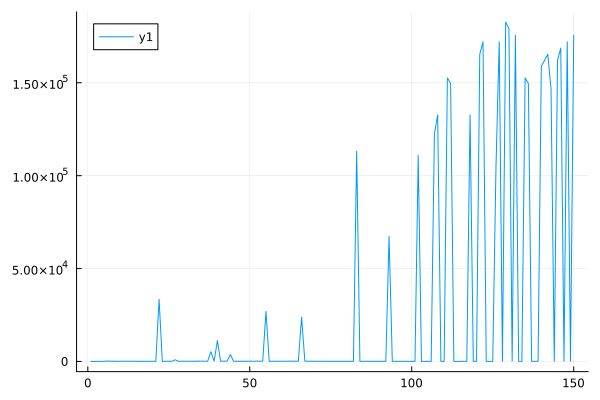

In [20]:
### Plot the stuff
println(waypoints_default);
plot(episode_test_reward_hook.rewards)


[[0.0, 0.0, 0.0], [2.9918019625475694, 0.0, 5.827927303605951]]


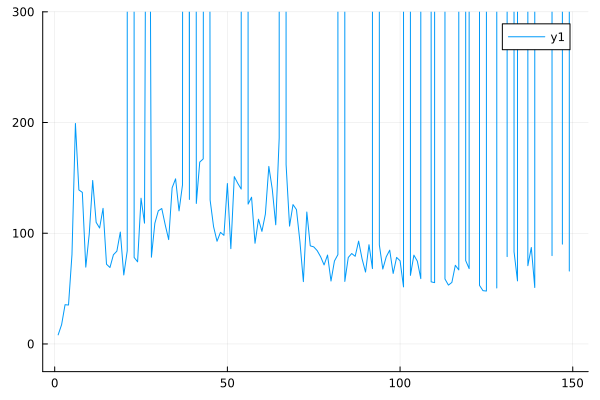

In [22]:
### Plot with set y-limits
println(waypoints_default);
plot(episode_test_reward_hook.rewards, ylim=(-25, 300))

In [ ]:
close_visualization(); # closes the MeshCat visualization